In [1]:
from ekonlpy.sentiment import MPCK
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## 금융통화위원회 의사록 어조 분석
- 의사록 어조 측정
1. 문장 : 금리 사전을 기반으로 긍/부정 카운트 후, 문장의 어조 계산 (문장 tone = (Pos - Neg) / (Pos + Neg))
2. 문서 : 문장의 어조를 계산한 값으로 0보다 크면 "Hawkish", 작으면 "Dovish"로 나누어 다시 문서 전체의 어조 계산 (문서 tone = (Pos - Neg) / (Pos + Neg))

In [2]:
# 금리 상승/하락 사전
pos_dict = pd.read_csv("../data/pos_dict.csv")
neg_dict = pd.read_csv("../data/neg_dict.csv")
# 금융통화위원회 의사록
min_df = pd.read_csv("../data/minutes_contents.csv")
# 기준 금리
base_df = pd.read_csv("../data/BOK_base_rate.csv")

mpck = MPCK()

# 각 사전의 단어들을 리스트로 분류
pos_list = pos_dict["word"].to_list()
neg_list = neg_dict["word"].to_list()
min_df

,date,title,contents
0,2010.05.12,금융통화위원회 의사록(2010년도 제10차)(2010.5.12),일부 위원은 남유럽사태 이후 각국이·｢ ｣금융기관에 대한 미시 거시 건전성감독의 중...
1,2010.07.09,금융통화위원회 의사록(2010년도 제14차)(2010.7.9),일부 위원은 금리 인상시 차익거래 유·｢ ｣인이 확대되어 외국인 채권투자자금 유입이...
2,2010.08.12,금융통화위원회 의사록(2010년도 제16차)(2010.8.12),@@@일부 위원은 연동대출 취급확대가COFIX｢ ｣통화정책에 미치는 영향으로 금리파...
3,2010.11.16,금융통화위원회 의사록(2010년도 제22차)(2010.11.16),일부 위원은 기준금리 인상이 내외금·｢ ｣리차 확대에 따른 재정거래 유인 증대를 초...
4,2010.12.09,금융통화위원회 의사록(2010년도 제24차)(2010.12.9),@@@일부 위원은 월중 기준금리 인상에도 불11｢ ｣구하고 국고채 년물 금리가 사상...
...,...,...,...
122,2023.04.11,금융통화위원회 의사록(2023년도 제7차)(2023.4.11),"일부 위원은 신협기구(상호금융, 신협, 새마을금고)의 부동산 관련 대출 비중이 과거..."
123,2024.05.23,금융통화위원회 의사록(2024년도 제10차)(2024.5.23),일부 위원은 유로지역 등 주요국이 미국에 앞서 선제적으로 정책금리를 인하할 가능성이...
124,2024.01.11,금융통화위원회 의사록(2024년도 제1차)(2024.1.11),일부 위원은 국내외 금융시장이 지난 통화정책방향 결정회의 이후 대체로 완화적이며 안...
125,2024.02.22,금융통화위원회 의사록(2024년도 제4차)(2024.2.22),일부 위원은 최근 금융·외환시장은 대체로 안정적인 흐름을 이어가고 있으며지난 통화정...


#### 데이터 전처리 함수

In [3]:
# 토큰화 + n-gram화
def stc_ngram(sentence):
    tokens = mpck.tokenize(sentence)
    ngrams = mpck.ngramize(tokens)
    result = tokens + ngrams
    return result

# 문장 어조 계산 후 라벨링
def get_label(df) :
    if df["tone_doc"] > 0 :
        return "Hawkish"
    elif df["tone_doc"] < 0 :
        return "Dovish"

## 금리 사전을 기반으로 긍/부정 카운트 후, 문장의 어조 계산

In [4]:
# 문장 tone 카운트 컬럼 생성
min_df["pos_cnt"] = np.nan
min_df["neg_cnt"] = np.nan

for i in tqdm(range(len(min_df))) :
    # 문장 tone의 최종 카운트가 될 변수
    pos_count = 0
    neg_count = 0
    sentences = min_df["contents"][i].split("@@@")
    for sentence in sentences :
        # 문서 별 문장 tone 카운트 변수
        up_count = 0
        down_count = 0
        # tokenize + ngramize
        ngram_list = stc_ngram(sentence)
        for ngram in ngram_list :
            if ngram in pos_list : # 금리 상승 사전
                up_count += 1
            elif ngram in neg_list : # 금리 하락 사전
                down_count += 1
        try:
            sentence_tone = (up_count - down_count) / (up_count + down_count)
        except ZeroDivisionError : # 연산 결과가 0
            sentence_tone = 0
        if sentence_tone > 0 :
            pos_count += 1
        elif sentence_tone < 0 :
            neg_count += 1
    # 카운트를 DataFrame에 업데이트
    min_df.at[i, "pos_cnt"] = pos_count
    min_df.at[i, "neg_cnt"] = neg_count
min_df.head(5)

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [00:46<00:00,  2.71it/s]


,date,title,contents,pos_cnt,neg_cnt
0,2010.05.12,금융통화위원회 의사록(2010년도 제10차)(2010.5.12),일부 위원은 남유럽사태 이후 각국이·｢ ｣금융기관에 대한 미시 거시 건전성감독의 중...,1.0,1.0
1,2010.07.09,금융통화위원회 의사록(2010년도 제14차)(2010.7.9),일부 위원은 금리 인상시 차익거래 유·｢ ｣인이 확대되어 외국인 채권투자자금 유입이...,2.0,2.0
2,2010.08.12,금융통화위원회 의사록(2010년도 제16차)(2010.8.12),@@@일부 위원은 연동대출 취급확대가COFIX｢ ｣통화정책에 미치는 영향으로 금리파...,1.0,0.0
3,2010.11.16,금융통화위원회 의사록(2010년도 제22차)(2010.11.16),일부 위원은 기준금리 인상이 내외금·｢ ｣리차 확대에 따른 재정거래 유인 증대를 초...,0.0,1.0
4,2010.12.09,금융통화위원회 의사록(2010년도 제24차)(2010.12.9),@@@일부 위원은 월중 기준금리 인상에도 불11｢ ｣구하고 국고채 년물 금리가 사상...,1.0,0.0


In [5]:
# 문장의 어조를 계산하여 문서의 어조 라벨링 컬럼 생성
min_df["tone_doc"] = (min_df["pos_cnt"] - min_df["neg_cnt"]) / (min_df["pos_cnt"] + min_df["neg_cnt"])
min_df["tone_doc_label"] = min_df.apply(get_label, axis = 1)
min_df.head(5)

,date,title,contents,pos_cnt,neg_cnt,tone_doc,tone_doc_label
0,2010.05.12,금융통화위원회 의사록(2010년도 제10차)(2010.5.12),일부 위원은 남유럽사태 이후 각국이·｢ ｣금융기관에 대한 미시 거시 건전성감독의 중...,1.0,1.0,0.0,None
1,2010.07.09,금융통화위원회 의사록(2010년도 제14차)(2010.7.9),일부 위원은 금리 인상시 차익거래 유·｢ ｣인이 확대되어 외국인 채권투자자금 유입이...,2.0,2.0,0.0,None
2,2010.08.12,금융통화위원회 의사록(2010년도 제16차)(2010.8.12),@@@일부 위원은 연동대출 취급확대가COFIX｢ ｣통화정책에 미치는 영향으로 금리파...,1.0,0.0,1.0,Hawkish
3,2010.11.16,금융통화위원회 의사록(2010년도 제22차)(2010.11.16),일부 위원은 기준금리 인상이 내외금·｢ ｣리차 확대에 따른 재정거래 유인 증대를 초...,0.0,1.0,-1.0,Dovish
4,2010.12.09,금융통화위원회 의사록(2010년도 제24차)(2010.12.9),@@@일부 위원은 월중 기준금리 인상에도 불11｢ ｣구하고 국고채 년물 금리가 사상...,1.0,0.0,1.0,Hawkish


In [6]:
# 문장, 문서의 어조 계산 결과 저장
min_df.to_csv("../data/minutes_tone_result.csv", encoding = "utf-8")

In [7]:
# 기준 금리 date 형식 변환
base_df["date"] = pd.to_datetime(base_df["date"]).dt.strftime("%Y.%m.%d")
base_df.head(5)

,date,rate
0,2008.02.29,5.0
1,2008.03.01,5.0
2,2008.03.02,5.0
3,2008.03.03,5.0
4,2008.03.04,5.0


In [8]:
# 의사록, 기준 금리 DataFrame 병합
b_m_df = pd.merge(min_df, base_df, on = "date", how = "inner")
b_m_df.head(5)

,date,title,contents,pos_cnt,neg_cnt,tone_doc,tone_doc_label,rate
0,2010.05.12,금융통화위원회 의사록(2010년도 제10차)(2010.5.12),일부 위원은 남유럽사태 이후 각국이·｢ ｣금융기관에 대한 미시 거시 건전성감독의 중...,1.0,1.0,0.0,None,2.00
1,2010.07.09,금융통화위원회 의사록(2010년도 제14차)(2010.7.9),일부 위원은 금리 인상시 차익거래 유·｢ ｣인이 확대되어 외국인 채권투자자금 유입이...,2.0,2.0,0.0,None,2.25
2,2010.08.12,금융통화위원회 의사록(2010년도 제16차)(2010.8.12),@@@일부 위원은 연동대출 취급확대가COFIX｢ ｣통화정책에 미치는 영향으로 금리파...,1.0,0.0,1.0,Hawkish,2.25
3,2010.11.16,금융통화위원회 의사록(2010년도 제22차)(2010.11.16),일부 위원은 기준금리 인상이 내외금·｢ ｣리차 확대에 따른 재정거래 유인 증대를 초...,0.0,1.0,-1.0,Dovish,2.50
4,2010.12.09,금융통화위원회 의사록(2010년도 제24차)(2010.12.9),@@@일부 위원은 월중 기준금리 인상에도 불11｢ ｣구하고 국고채 년물 금리가 사상...,1.0,0.0,1.0,Hawkish,2.50


## 의사록 어조와 기준 금리의 상관계수 산출

In [9]:
corre = b_m_df["tone_doc"].corr(b_m_df["rate"])
print(f"상관 계수 : {corre}")

상관 계수 : 0.11170354061243205


## 상관관계 시각화 그래프

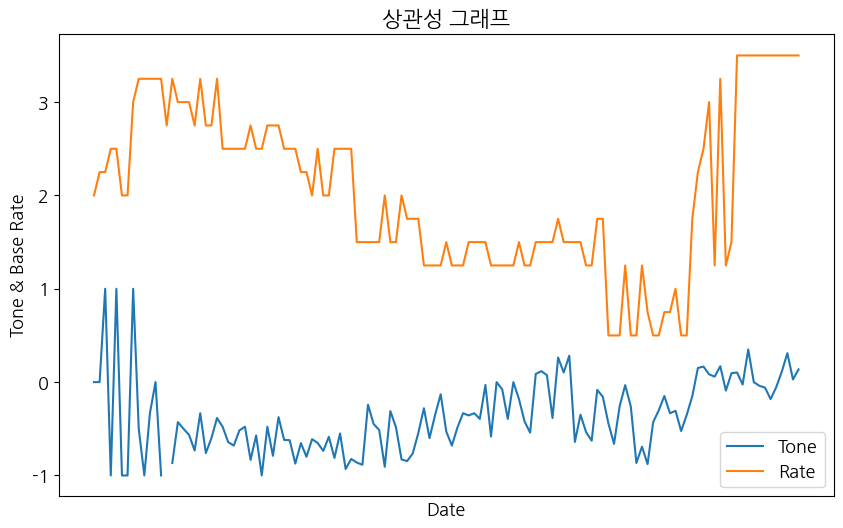

In [10]:
# x, y 넘파이 배열로 변환
x = np.array(b_m_df["date"])
y1 = np.array(b_m_df["tone_doc"])
y2 = np.array(b_m_df["rate"])

plt.rc("font", family = "NanumGothic", size = 13)
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize = (10, 6))
plt.plot(x, y1, label = "Tone")
plt.plot(x, y2, label = "Rate")

plt.xlabel("Date")
plt.ylabel("Tone & Base Rate")
plt.title("상관성 그래프")
plt.xticks([])
plt.legend()

plt.show()